In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

In [2]:
import numpy as np
import nibabel as nib
import pandas as pd
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchio as tio
from models.segmentation import *
from models.sfcn import *
from models.pretrained_cnn import *
from models.vnet_regressor import *
from models.sfcn_fds import *
from models.pretrained_cnn_fds import *
from models.lds_utils import get_lds_kernel_window
from models.loss import weighted_focal_mse_loss, weighted_focal_l1_loss
from collections import Counter
from scipy.ndimage import zoom, convolve1d
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import gc
import wandb

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Sat Jun 17 21:42:30 2023
TorchIO version: 0.18.83


In [4]:
RANDOM_SEED = 551

In [5]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Count of using GPUs: 2


In [7]:
def prepare_dataset(image_dir='./input_nifti_crop/', label_dir='./seg_nifti_crop/'):
        # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
    filenames = os.listdir(label_dir)  # image_dir랑 label_dir에 저장되어있는 파일명이 같음

    subjects = []
    for filename in tqdm(filenames):
        subject = tio.Subject(
            img = tio.ScalarImage(image_dir + filename),
            label = tio.LabelMap(label_dir + filename))   # label => LabelMap!!!!!!!
        subjects.append(subject)
    dataset = tio.SubjectsDataset(subjects)
    return subjects, dataset

In [8]:
def run_training(net_seg, loss_type):
    running_seg_loss = 0.0
    running_seg_score = 0.0

    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']

#         print('before')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()

        
#         print('labels:', labels[0,0,:,:,labels.shape[4]//2])
        
#         l1=(labels==1)
#         l0=(labels==0)
#         labels = torch.cat((l0,l1),1)
        
#         print('after')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()
#         plt.imshow(labels[0,1,:,:,labels.shape[4]//2])
#         plt.show()
#         break

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)
#         if (i % effective_batchsize) == 0:
        optimizer_seg.zero_grad()
        
        net_seg.train()
        outputs_seg = net_seg(inputs)

        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
#         ##
#         print('input:',outputs_seg.shape,'target:', labels.shape)
        loss_seg, score_seg = criterion_seg(outputs_seg, labels, loss=loss_type)

        loss_seg.backward()
        optimizer_seg.step()

        running_seg_loss += loss_seg.detach().cpu().item()
        running_seg_score += score_seg.detach().cpu().item()
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_loss = running_seg_loss / len(train_loader)
    avg_score = running_seg_score / len(train_loader)
    
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    
    return avg_loss, avg_score, one_output_seg, one_output_img, one_output_lbl

In [9]:
def run_validation(net_seg, loss_type):
    net_seg.eval()
  
    running_seg_loss = 0.0
    running_seg_score = 0.0
    
    total_output_seg=[]
    total_output_img=[]
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    
            
#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)
            
            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)
            
            net_seg.eval()
            
            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())
            
            outputs_seg = net_seg(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())
            
            loss_seg, score_seg = criterion_seg(outputs_seg, labels, loss=loss_type)
            
            running_seg_loss += loss_seg.detach().cpu().item()
            running_seg_score += score_seg.detach().cpu().item()
            
    avg_loss = running_seg_loss / len(valid_loader)
    avg_score = running_seg_score / len(valid_loader)
    
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)

    return avg_loss, avg_score, one_output_seg, one_output_img, one_output_lbl, total_output_seg, total_output_img

In [10]:
image_dir = './input_nifti_300/'  #'./input_nifti/'
label_dir = './seg_nifti_300/'  #'./input_nifti_seg/'
subjects, dataset = prepare_dataset(image_dir, label_dir)
print('Dataset size : ', len(dataset), 'subjects')

100%|██████████████████████████████████████| 130/130 [00:00<00:00, 14521.28it/s]

Dataset size :  130 subjects


In [11]:
set_seed()

split_rate = 0.8
_, _, _, d = dataset[0].shape
w, h = 300, 300
img_size = 192  # [16,32,48,64,80,96,112,128,144,160, 176,192,208,224]
sample_rate = 300 / img_size

# transformation
preprocess = tio.Compose([
    tio.Resample(sample_rate),
#     tio.Resample(1.5),
#     tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
    tio.OneHot(),
])

train_transform = tio.Compose([
    tio.Resample(sample_rate),
#     tio.Resample(1.5),
#     tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
    tio.OneHot(),
])

valid_transform = tio.Compose([
    tio.Resample(sample_rate),
#     tio.Resample(1.5),
#     tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
    tio.OneHot(),
])

# data split
set_seed()
num_subjects = len(dataset)
num_train_subjects = int(split_rate * num_subjects)
num_valid_subjects = num_subjects - num_train_subjects
num_split_subjects = num_train_subjects, num_valid_subjects
train_subjects, valid_subjects = random_split(subjects, num_split_subjects)

# all data set
dataset = tio.SubjectsDataset(subjects, transform=preprocess)

# training set
train_set = tio.SubjectsDataset(
    train_subjects, transform=train_transform)
# validation set
valid_set = tio.SubjectsDataset(
    valid_subjects, transform=valid_transform)

print('Training set:', len(train_set), 'subjects')
print('Validation set:', len(valid_set), 'subjects')

Training set: 104 subjects
Validation set: 26 subjects


In [12]:
batch_size = 4
valid_batch_size = 4

# weight 값 얻기 용
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)

# hyper-paramter tuning 용
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)
valid_loader = DataLoader(valid_set, batch_size=valid_batch_size, num_workers=16)

In [13]:
normalization = 'groupnorm'
num_epochs = 5
lr = 0.001
optim_class = optim.Adam

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████| 7/7 [00:25<00:00,  3.68s/it]


# EPOCH 1 / 5


100%|█████████████████████████████████████████████| 7/7 [00:28<00:00,  4.14s/it]


# EPOCH 2 / 5


100%|█████████████████████████████████████████████| 7/7 [00:29<00:00,  4.15s/it]


# EPOCH 3 / 5


100%|█████████████████████████████████████████████| 7/7 [00:28<00:00,  4.05s/it]


# EPOCH 4 / 5


100%|█████████████████████████████████████████████| 7/7 [00:28<00:00,  4.06s/it]


# EPOCH 5 / 5
Train


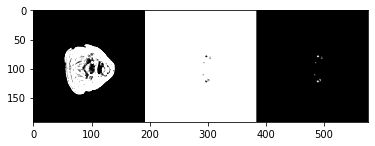

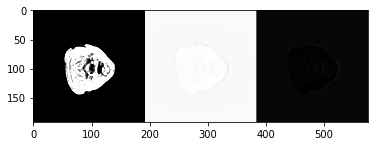

Valid


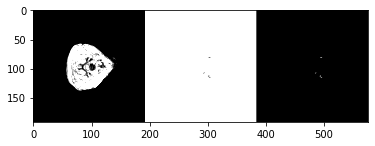

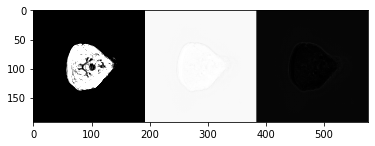

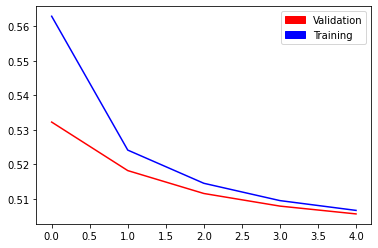

train_loss,█▃▂▁▁
train_score,▁▆▇██
valid_loss,█▄▃▂▁
valid_score,▁▅▆▇█
train_loss,0.50666
train_score,0.49334
valid_loss,0.50564
valid_score,0.49436


In [14]:
# SegLoss 코드 시험
set_seed()
net_seg = VNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet", "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__},
    notes='Dice 코드 시험용'
)
wandb.watch(net_seg)

train_losses = []
validation_losses = []
S = 192 // 2

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = SegLoss()

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg, "dice")
    valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg, "dice")
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[1,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
    valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
    valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
    valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")
    
#     lbl_train = train_input_lbl[0, :, : ,S]
#     seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]
    
    if (epoch+1)%5==0:
        print('Train')
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.show()
        
        print('Valid')
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()  
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.show()
        
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
    wandb.log({"train_loss": train_loss, "valid_loss": valid_loss,
               "train_score": train_score, "valid_score": valid_score,
               "train_img": train_img, "valid_img": valid_img,
               "train_label": train_truth, "train_pred": train_pred,
               "valid_label": valid_truth, "valid_pred": valid_pred})
wandb.finish()

In [14]:
normalization = 'groupnorm'
num_epochs = 30
lr = 0.001
optim_class = optim.Adam

In [15]:
# Segmentation weight 생성
for blocknum in range(1, 5):
    set_seed()
    net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
    net_seg.cuda()

    wandb.init(
        project='202303-segmentation',
        config={"model": "VNet-%d"%blocknum, "input_size": img_size,
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "DiceLoss", "optimizer": optim_class.__name__},
        notes='Segmentation weight를 생성하기 위함 (300x300x300 => 192x192x192), change num of convolution layers'
    )
    wandb.watch(net_seg)

    train_losses = []
    S = 192 // 2
    min_train_loss = 1.0

    optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
    criterion_seg = SegLoss()
    # criterion_seg = GeneralizedDiceLoss()
    # scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

    set_seed()
    for epoch in range(num_epochs):
        train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg, "dice")
        print('# EPOCH %d / %d'%(epoch+1, num_epochs))
        train_losses.append(train_loss)

        train_img = wandb.Image(train_img_part[0,:,:,S])
        train_truth = wandb.Image(train_input_lbl[1,:,:,S], caption="Ground truth")
        train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")

        if min_train_loss > train_loss:
            min_train_loss = train_loss
            torch.save(net_seg.state_dict(), 'pretrained/seg_2305_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size))        

    #     lbl_train = train_input_lbl[0, :, : ,S]
    #     seg_train = train_seg_part[0, :, : , S]
    #     lbl_valid = valid_input_lbl_part[0, :, : , S]
    #     seg_valid = valid_output_seg_part[0, :, : , S]


    #     if i%5==0:
    #         print('Train')
    # #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
    #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
    #         plt.show()
    # #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
    #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
    #         plt.show()

    #         print('Valid')
    # #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
    #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
    #         plt.show()  
    # #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
    #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
    #         plt.show()

    #         # loss curve
    #         plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
    #         red_patch = mpatches.Patch(color='red', label='Validation')
    #         blue_patch = mpatches.Patch(color='blue', label='Training')
    #         plt.legend(handles=[red_patch, blue_patch])
    #         plt.show()


        wandb.log({"train_loss": train_loss, "train_score": train_score,
                   "train_img": train_img, "train_label": train_truth, "train_pred": train_pred})
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


100%|███████████████████████████████████████████| 26/26 [01:21<00:00,  3.14s/it]


# EPOCH 1 / 30


100%|███████████████████████████████████████████| 26/26 [01:18<00:00,  3.01s/it]


# EPOCH 2 / 30


100%|███████████████████████████████████████████| 26/26 [01:21<00:00,  3.14s/it]


# EPOCH 3 / 30


100%|███████████████████████████████████████████| 26/26 [01:23<00:00,  3.23s/it]


# EPOCH 4 / 30


100%|███████████████████████████████████████████| 26/26 [01:21<00:00,  3.13s/it]


# EPOCH 5 / 30


100%|███████████████████████████████████████████| 26/26 [01:17<00:00,  3.00s/it]


# EPOCH 6 / 30


100%|███████████████████████████████████████████| 26/26 [01:18<00:00,  3.02s/it]


# EPOCH 7 / 30


100%|███████████████████████████████████████████| 26/26 [01:24<00:00,  3.26s/it]


# EPOCH 8 / 30


100%|███████████████████████████████████████████| 26/26 [01:22<00:00,  3.18s/it]


# EPOCH 9 / 30


100%|███████████████████████████████████████████| 26/26 [01:22<00:00,  3.19s/it]


# EPOCH 10 / 30


100%|███████████████████████████████████████████| 26/26 [01:23<00:00,  3.22s/it]


# EPOCH 11 / 30


100%|███████████████████████████████████████████| 26/26 [01:25<00:00,  3.27s/it]


# EPOCH 12 / 30


100%|███████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it]


# EPOCH 13 / 30


100%|███████████████████████████████████████████| 26/26 [01:32<00:00,  3.55s/it]


# EPOCH 14 / 30


100%|███████████████████████████████████████████| 26/26 [01:33<00:00,  3.60s/it]


# EPOCH 15 / 30


100%|███████████████████████████████████████████| 26/26 [01:28<00:00,  3.42s/it]


# EPOCH 16 / 30


100%|███████████████████████████████████████████| 26/26 [01:29<00:00,  3.43s/it]


# EPOCH 17 / 30


100%|███████████████████████████████████████████| 26/26 [01:34<00:00,  3.62s/it]


# EPOCH 18 / 30


100%|███████████████████████████████████████████| 26/26 [01:30<00:00,  3.47s/it]


# EPOCH 19 / 30


100%|███████████████████████████████████████████| 26/26 [01:34<00:00,  3.65s/it]


# EPOCH 20 / 30


100%|███████████████████████████████████████████| 26/26 [01:31<00:00,  3.53s/it]


# EPOCH 21 / 30


100%|███████████████████████████████████████████| 26/26 [01:28<00:00,  3.42s/it]


# EPOCH 22 / 30


100%|███████████████████████████████████████████| 26/26 [01:28<00:00,  3.41s/it]


# EPOCH 23 / 30


100%|███████████████████████████████████████████| 26/26 [01:33<00:00,  3.61s/it]


# EPOCH 24 / 30


100%|███████████████████████████████████████████| 26/26 [01:33<00:00,  3.61s/it]


# EPOCH 25 / 30


100%|███████████████████████████████████████████| 26/26 [01:36<00:00,  3.71s/it]


# EPOCH 26 / 30


100%|███████████████████████████████████████████| 26/26 [01:36<00:00,  3.69s/it]


# EPOCH 27 / 30


100%|███████████████████████████████████████████| 26/26 [01:30<00:00,  3.50s/it]


# EPOCH 28 / 30


100%|███████████████████████████████████████████| 26/26 [01:27<00:00,  3.36s/it]


# EPOCH 29 / 30


100%|███████████████████████████████████████████| 26/26 [01:31<00:00,  3.50s/it]


# EPOCH 30 / 30


train_loss,█▇▇▇▇▆▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▂▂▂▂▃▃▄▇▇████████████████████
train_loss,0.2179
train_score,0.7821


100%|███████████████████████████████████████████| 26/26 [01:26<00:00,  3.33s/it]


# EPOCH 1 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 2 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]


# EPOCH 3 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.81s/it]


# EPOCH 4 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.77s/it]


# EPOCH 5 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.77s/it]


# EPOCH 6 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.77s/it]


# EPOCH 7 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.83s/it]


# EPOCH 8 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.83s/it]


# EPOCH 9 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.81s/it]


# EPOCH 10 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 11 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 12 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.77s/it]


# EPOCH 13 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.83s/it]


# EPOCH 14 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.77s/it]


# EPOCH 15 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]


# EPOCH 16 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.83s/it]


# EPOCH 17 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.77s/it]


# EPOCH 18 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.74s/it]


# EPOCH 19 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]


# EPOCH 20 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]


# EPOCH 21 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.81s/it]


# EPOCH 22 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.77s/it]


# EPOCH 23 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.77s/it]


# EPOCH 24 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]


# EPOCH 25 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]


# EPOCH 26 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.78s/it]


# EPOCH 27 / 30


100%|███████████████████████████████████████████| 26/26 [01:10<00:00,  2.72s/it]


# EPOCH 28 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.80s/it]


# EPOCH 29 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.75s/it]


# EPOCH 30 / 30


train_loss,█▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▂▁▁▁▁▁▁▁▁
train_score,▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▇████████
train_loss,0.21495
train_score,0.78505


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.76s/it]


# EPOCH 1 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.86s/it]


# EPOCH 2 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 3 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 4 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 5 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 6 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.85s/it]


# EPOCH 7 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.85s/it]


# EPOCH 8 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 9 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 10 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.76s/it]


# EPOCH 11 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.88s/it]


# EPOCH 12 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 13 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 14 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.75s/it]


# EPOCH 15 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.83s/it]


# EPOCH 16 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 17 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.85s/it]


# EPOCH 18 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 19 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 20 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 21 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.83s/it]


# EPOCH 22 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 23 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 24 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 25 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 26 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 27 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.86s/it]


# EPOCH 28 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 29 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.77s/it]


# EPOCH 30 / 30


train_loss,█▇▇▆▆▆▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▂▂▃▃▃▃▅▇▇████████████████████
train_loss,0.20406
train_score,0.79594


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 1 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.81s/it]


# EPOCH 2 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 3 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.81s/it]


# EPOCH 4 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 5 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 6 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.88s/it]


# EPOCH 7 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.86s/it]


# EPOCH 8 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 9 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 10 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 11 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.85s/it]


# EPOCH 12 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.78s/it]


# EPOCH 13 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 14 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.86s/it]


# EPOCH 15 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.86s/it]


# EPOCH 16 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.88s/it]


# EPOCH 17 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.76s/it]


# EPOCH 18 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.85s/it]


# EPOCH 19 / 30


100%|███████████████████████████████████████████| 26/26 [01:14<00:00,  2.85s/it]


# EPOCH 20 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.73s/it]


# EPOCH 21 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.82s/it]


# EPOCH 22 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.81s/it]


# EPOCH 23 / 30


100%|███████████████████████████████████████████| 26/26 [01:11<00:00,  2.76s/it]


# EPOCH 24 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 25 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 26 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.85s/it]


# EPOCH 27 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.85s/it]


# EPOCH 28 / 30


100%|███████████████████████████████████████████| 26/26 [01:12<00:00,  2.79s/it]


# EPOCH 29 / 30


100%|███████████████████████████████████████████| 26/26 [01:13<00:00,  2.84s/it]


# EPOCH 30 / 30


train_loss,█▇▇▇▇▇▇▇▇▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▂▂▂▂▂▂▂▂▃▅▇▇█████████████████
train_loss,0.20621
train_score,0.79379


In [14]:
# Evaluation

text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

for blocknum in range(1, 5):
    normalization = 'groupnorm'
    criterion = SegMetrics()
    
    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2305_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    running_pa = 0.0
    running_dice = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_spec = 0.0

    total_output_seg=[]
    total_output_img=[]

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())

            pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

            running_pa += pixel_acc.detach().cpu().item()
            running_dice += dice.detach().cpu().item()
            running_prec += precision.detach().cpu().item()
            running_rec += recall.detach().cpu().item()
            running_spec += specificity.detach().cpu().item()

    avg_pa = running_pa / len(data_loader)
    avg_dice = running_dice / len(data_loader)
    avg_prec = running_prec / len(data_loader)
    avg_rec = running_rec / len(data_loader)
    avg_spec = running_spec / len(data_loader)

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)
    
    text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)
text += "===============================================================================\n"
print(text)

100%|███████████████████████████████████████████| 33/33 [01:27<00:00,  2.66s/it]


-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-1	1.000	0.781	0.731	0.871	0.871
VNet-2	1.000	0.785	0.732	0.882	0.882
VNet-3	1.000	0.793	0.732	0.908	0.908
VNet-4	1.000	0.792	0.741	0.880	0.880



In [15]:
# Evaluation

text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

for blocknum in range(1, 5):
    normalization = 'groupnorm'
    criterion = SegMetrics()
    
    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    running_pa = 0.0
    running_dice = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_spec = 0.0

    total_output_seg=[]
    total_output_img=[]

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())

            pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

            running_pa += pixel_acc.detach().cpu().item()
            running_dice += dice.detach().cpu().item()
            running_prec += precision.detach().cpu().item()
            running_rec += recall.detach().cpu().item()
            running_spec += specificity.detach().cpu().item()

    avg_pa = running_pa / len(data_loader)
    avg_dice = running_dice / len(data_loader)
    avg_prec = running_prec / len(data_loader)
    avg_rec = running_rec / len(data_loader)
    avg_spec = running_spec / len(data_loader)

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)
    
    text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
text += "===============================================================================\n"
print(text)

100%|███████████████████████████████████████████| 33/33 [01:29<00:00,  2.71s/it]


-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-1	0.998	0.603	0.562	0.842	0.842
VNet-2	0.998	0.614	0.569	0.861	0.861
VNet-3	0.998	0.615	0.569	0.874	0.874
VNet-4	0.998	0.584	0.551	0.753	0.753



In [14]:
# Evaluation

text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

for blocknum in range(1, 5):
    normalization = 'groupnorm'
    criterion = SegMetrics()
    
    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    running_pa = 0.0
    running_dice = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_spec = 0.0

    total_output_seg=[]
    total_output_img=[]

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())

            outputs_seg = (outputs_seg >= 0.5).float()   # 확률값 => 0,1
            pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

            running_pa += pixel_acc.detach().cpu().item()
            running_dice += dice.detach().cpu().item()
            running_prec += precision.detach().cpu().item()
            running_rec += recall.detach().cpu().item()
            running_spec += specificity.detach().cpu().item()

    avg_pa = running_pa / len(data_loader)
    avg_dice = running_dice / len(data_loader)
    avg_prec = running_prec / len(data_loader)
    avg_rec = running_rec / len(data_loader)
    avg_spec = running_spec / len(data_loader)

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)
    
    text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
text += "===============================================================================\n"
print(text)

100%|███████████████████████████████████████████| 33/33 [01:07<00:00,  2.03s/it]


-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-1	1.000	0.777	0.735	0.849	0.849
VNet-2	1.000	0.786	0.737	0.872	0.872
VNet-3	1.000	0.787	0.733	0.887	0.887
VNet-4	1.000	0.742	0.743	0.751	0.751



  0%|                                                    | 0/33 [00:32<?, ?it/s]


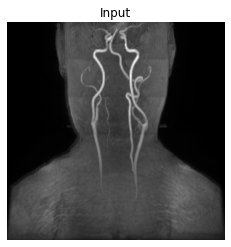

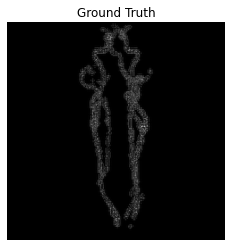

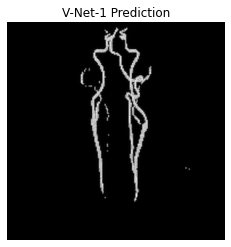

  0%|                                                    | 0/33 [00:50<?, ?it/s]


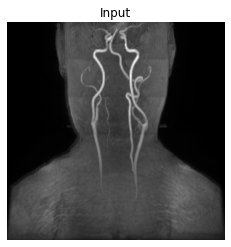

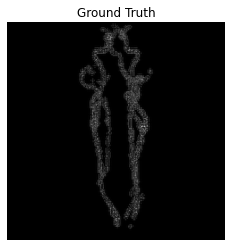

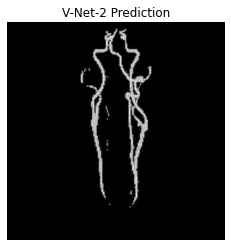

  0%|                                                    | 0/33 [00:56<?, ?it/s]


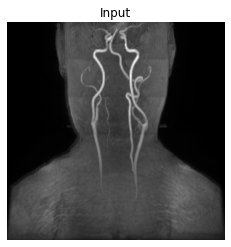

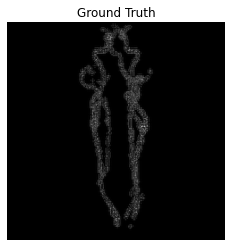

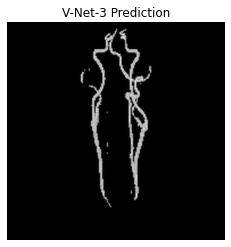

  0%|                                                    | 0/33 [00:46<?, ?it/s]


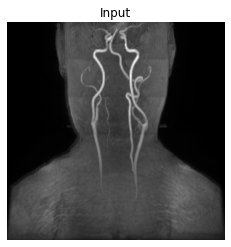

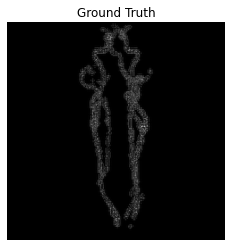

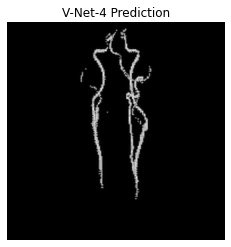

In [15]:
# Evaluation (예시 이미지)
from scipy.ndimage import rotate, zoom

for blocknum in range(1, 5):
    normalization = 'groupnorm'

    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            outputs_seg = (outputs_seg >= 0.5).float()
            break

    one_output_seg = outputs_seg.detach().cpu().numpy()[1]
    one_output_img = inputs.detach().cpu().numpy()[1]
    one_output_lbl = labels.detach().cpu().numpy()[1]
    scale = 300 / img_size

    plt.title("Input")
    img_in = zoom(one_output_img[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("Ground Truth")
    img_gt = zoom(one_output_lbl[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("V-Net-{} Prediction".format(blocknum))
    img_p = zoom(one_output_seg[1], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    # nifti_img = nib.Nifti1Image(img, affine=np.eye(4))

In [26]:
one_output_seg[1].shape, one_output_img[0].shape, one_output_lbl[1].shape

((192, 192, 192), (192, 192, 192), (192, 192, 192))

VNet-4 :


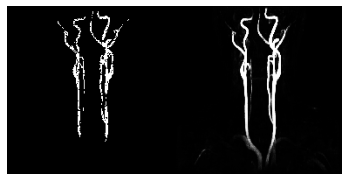

VNet-4 :


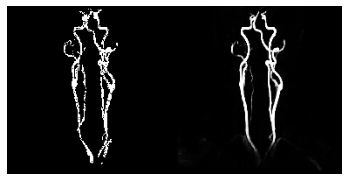

VNet-4 :


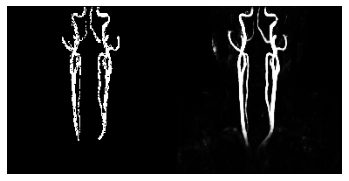

VNet-4 :


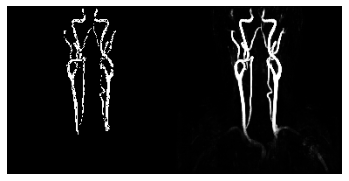

In [38]:
for i in range(len(outputs_seg)):
    one_output_seg = outputs_seg.detach().cpu().numpy()[i]
    one_output_img = inputs.detach().cpu().numpy()[i]
    one_output_lbl = labels.detach().cpu().numpy()[i]

    print('VNet-{} :'.format(blocknum))
    plt.imshow(np.squeeze(np.concatenate((rotate(np.max(one_output_lbl[1], axis=1), 90),rotate(np.max(one_output_seg[1], axis=1), 90)),axis=1)),vmin=0,vmax=1,cmap='gray') # label
    plt.axis('off')
    plt.show()